In [1]:
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append("src")

import utils

In [2]:
random.seed(42)
torch.manual_seed(42)

In [3]:
train = utils.read_data("train")
test = utils.read_data("test")

In [4]:
len(train)

468

In [5]:
train_sequences = [(train[key]['ts'].to_numpy(), 1 if train[key]['class'] == "a" else 0) for key in train]
test_sequences = [(test[key]['ts'].to_numpy(), 1 if test[key]['class'] == "a" else 0) for key in test]
val_sequences = train_sequences[200:]
train_sequences = train_sequences[:200]

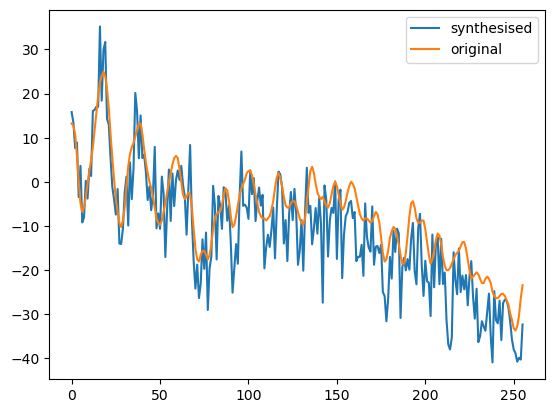

In [6]:
from tsaug import Crop, Quantize, Drift, AddNoise

augmentor = (
        Crop(size=256) + Quantize(n_levels=[10, 20, 30]) + Drift(max_drift=(0.05, 0.2)) @ 0.8 + AddNoise(scale=0.1))
x1 = np.array(train_sequences[0][0]).T
synthetic_x1 = augmentor.augment(x1)

plt.plot(synthetic_x1[0], label="synthesised")
plt.plot(x1[0], label="original")
plt.legend()
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset


class EEGDataset(Dataset):
    def __init__(self, sequences, synthetic: bool = False):
        self.sequences = sequences
        self.synthetic = synthetic
        if self.synthetic:
            self.augmentor = (Crop(size=256) + Quantize(n_levels=[10, 20, 30])
                              + Drift(max_drift=(0.05, 0.2)) @ 0.8 + AddNoise(scale=0.1))

    def __len__(self):
        return len(self.sequences) * 5

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx // 5]
        if self.synthetic:
            sequence = self.augmentor.augment(sequence.T).T
        return dict(
            sequence=torch.Tensor(sequence),
            label=torch.tensor(label).long()
        )

In [8]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader


class EEGDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, val_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = EEGDataset(self.train_sequences, True)
        self.val_dataset = EEGDataset(self.val_sequences)
        self.test_dataset = EEGDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=6
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=6
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=6
        )

In [9]:
import torch.nn as nn
from typing import Literal


class EEGModel(nn.Module):
    def __init__(self, n_features: int = 64, n_hidden: int = 256, n_layers: int = 3,
                 rnn: Literal["lstm", "gru"] = "lstm", dropout: float = 0.3):
        super().__init__()

        match rnn:
            case "lstm":
                self.rnn_class = nn.LSTM
            case "gru":
                self.rnn_class = nn.GRU
            case _:
                raise ValueError("Invalid rnn architecture")

        self.rnn = self.rnn_class(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.classifier = nn.Linear(2 * n_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.rnn.to(x.device)
        self.classifier.to(x.device)

        out, _ = self.rnn(x)
        out = out.max(-2).values
        out = self.classifier(out)
        out = self.sigmoid(out)
        return out

In [10]:
import torch.optim as optim
from torchmetrics import Accuracy


class EEGPredictior(pl.LightningModule):
    def __init__(self, n_features, *args, **kwargs):
        super().__init__()
        self.model = EEGModel(n_features, *args, **kwargs)
        self.criterion = nn.BCELoss()
        self.acc = Accuracy(task="binary")

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.float().unsqueeze(-1))
        return loss, output

    def predict(self, sequence):
        loss, output = self(torch.Tensor(sequence))
        predictions = (output > 0.5).float().squeeze(-1)
        return predictions

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = (outputs > 0.5).float().squeeze(-1)
        step_accuracy = self.acc(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = (outputs > 0.5).float().squeeze(-1)
        step_accuracy = self.acc(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = (outputs > 0.5).float().squeeze(-1)
        step_accuracy = self.acc(predictions, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

In [11]:
model = EEGPredictior(n_features=64, n_hidden=256, rnn="lstm", n_layers=2, dropout=0.3)

In [12]:
%reload_ext tensorboard
%tensorboard --logdir./lightning_logs

Launching TensorBoard...

In [13]:
data_module = EEGDataModule(train_sequences, val_sequences, test_sequences, 32)

In [14]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, data_module)

/home/jkarolczak/miniconda3/envs/eeg/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/jkarolczak/Projects/eeg-alcoholics/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | EEGModel       | 2.2 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.948     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/jkarolczak/miniconda3/envs/eeg/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 32: 'val_loss' reached 0.49399 (best 0.49399), saving model to '/home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 64: 'val_loss' reached 0.41529 (best 0.41529), saving model to '/home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 96: 'val_loss' reached 0.31873 (best 0.31873), saving model to '/home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 128: 'val_loss' reached 0.31768 (best 0.31768), saving model to '/home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 160: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 192: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 224: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 256: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 288: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 320: 'val_loss' reached 0.29948 (best 0.29948), saving model to '/home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
trainer.test(dataloaders=data_module.test_dataloader())

/home/jkarolczak/miniconda3/envs/eeg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/jkarolczak/Projects/eeg-alcoholics/checkpoints/best-checkpoint-v47.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.918749988079071
        test_loss           0.22188563644886017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22188563644886017, 'test_accuracy': 0.918749988079071}]